In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from rich import table
from numba import njit
from rich.text import Text
from dateutil import parser
from rich.panel import Panel
import matplotlib.pyplot as plt
from rich.console import Console
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from rich.console import Console
from rich.progress import Progress, BarColumn, TextColumn, TimeElapsedColumn
from rich.table import Table
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import pandas as pd

In [2]:
df = pd.read_csv('./Data/bank_transactions.csv')

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
datasets = df.drop(columns=['TransactionID', 'CustomerID'])

In [5]:
datasets.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [6]:
datasets.shape

(1048567, 7)

In [7]:
datasets.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [8]:
@njit
def _batch_age_calc(by, bm, bd, ty, tm, td):
    n = by.shape[0]
    ages = np.empty(n, dtype=np.int64)
    for i in range(n):
        age = ty - by[i]
        if tm < bm[i] or (tm == bm[i] and td < bd[i]):
            age -= 1
        ages[i] = age
    return ages

def age_series(dob_series: pd.Series) -> pd.Series:
    parts = dob_series.str.split("/", expand=True)
    d = parts[0].astype(int).to_numpy()
    m = parts[1].astype(int).to_numpy()
    y_raw = parts[2]
    mask2 = y_raw.str.len() == 2
    y = np.where(mask2, ("19" + y_raw).astype(int), y_raw.astype(int))
    tm = time.localtime()
    ty, tm_m, td = tm.tm_year, tm.tm_mon, tm.tm_mday
    ages = _batch_age_calc(y, m, d, ty, tm_m, td)
    return pd.Series(ages, index=dob_series.index)

In [9]:
import pandas as pd

# 1) définition des fonctions (à placer en début de script ou dans un module)
def clean_date_series(dob_series: pd.Series) -> pd.Series:
    s = dob_series.str.strip()
    return pd.to_datetime(s, dayfirst=True, infer_datetime_format=True, errors='coerce')

def clean_date_series_unix(dob_series: pd.Series) -> pd.Series:
    dt = clean_date_series(dob_series)
    ts = dt.astype('int64') // 10**9
    return ts.astype('Int64')


In [10]:
df.dropna(inplace=True)

In [11]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


In [12]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [13]:
df.shape

(1041614, 9)

In [14]:
# Convert dates to datetime using dateutil parser
df["age"] = age_series(df["CustomerDOB"])
df["TransactionDate"] = clean_date_series_unix(df["TransactionDate"])
print(df)

        TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053     10/1/94          F     JAMSHEDPUR   
1                  T2   C2142763      4/4/57          M        JHAJJAR   
2                  T3   C4417068    26/11/96          F         MUMBAI   
3                  T4   C5342380     14/9/73          F         MUMBAI   
4                  T5   C9031234     24/3/88          F    NAVI MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229      8/4/90          M      NEW DELHI   
1048563      T1048564   C6459278     20/2/92          M         NASHIK   
1048564      T1048565   C6412354     18/5/89          M      HYDERABAD   
1048565      T1048566   C6420483     30/8/78          M  VISAKHAPATNAM   
1048566      T1048567   C8337524      5/3/84          M           PUNE   

         CustAccountBalance  TransactionDate  TransactionTime  \
0                  17819.05       1470096000  

/var/folders/m9/n5d54_nd60l_9j9pz5np7rsm0000gn/T/ipykernel_97261/3228231324.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, dayfirst=True, infer_datetime_format=True, errors='coerce')
/var/folders/m9/n5d54_nd60l_9j9pz5np7rsm0000gn/T/ipykernel_97261/3228231324.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(s, dayfirst=True, infer_datetime_format=True, errors='coerce')


In [15]:
# Méthode : on convertit la date, puis on ajoute les heures/minutes/secondes
df['datetime'] = (
    pd.to_datetime(df['TransactionDate'], unit='s')
    + pd.to_timedelta(df['TransactionTime'] // 10000, unit='h')
    + pd.to_timedelta((df['TransactionTime'] % 10000) // 100, unit='m')
    + pd.to_timedelta(df['TransactionTime'] % 100, unit='s')
)

# Si vous voulez aussi un timestamp Unix (en secondes) :
df['unix_ts'] = df['datetime'].astype('int64') // 10**9

On a des valeur d'age de 225 ans car la date de naissance est en 1800. on va les drop pour eviter les valeurs indésirables.

In [16]:
df = df.drop(df[df['age'] > 125].index)

In [17]:
df.shape

(985322, 12)

In [18]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),age,datetime,unix_ts
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,1470096000,143207,25.0,31,2016-08-02 14:32:07,1470148327
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,1470096000,141858,27999.0,68,2016-08-02 14:18:58,1470147538
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,1470096000,142712,459.0,28,2016-08-02 14:27:12,1470148032
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,1470096000,142714,2060.0,51,2016-08-02 14:27:14,1470148034
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,1470096000,181156,1762.5,37,2016-08-02 18:11:56,1470161516


Comme on a l'age on peut DROP la date de naissance.

In [19]:
df = df.drop(columns=['CustomerDOB','TransactionDate','TransactionTime','datetime'])

In [20]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()
One_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [21]:
datasets = df.copy()
datasets.drop(columns=['TransactionID', 'CustomerID'], inplace=True)

In [22]:
datasets

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),age,unix_ts
0,F,JAMSHEDPUR,17819.05,25.0,31,1470148327
1,M,JHAJJAR,2270.69,27999.0,68,1470147538
2,F,MUMBAI,17874.44,459.0,28,1470148032
3,F,MUMBAI,866503.21,2060.0,51,1470148034
4,F,NAVI MUMBAI,6714.43,1762.5,37,1470161516
...,...,...,...,...,...,...
1048562,M,NEW DELHI,7635.19,799.0,35,1474224504
1048563,M,NASHIK,27311.42,460.0,33,1474223854
1048564,M,HYDERABAD,221757.06,770.0,36,1474223593
1048565,M,VISAKHAPATNAM,10117.87,1000.0,46,1474224426


In [23]:
ordinal_col = ['CustLocation']
label_col = ['CustGender']
# col_to_onehot = ['CustLocation']
scale_col = ['CustAccountBalance','TransactionAmount (INR)','age','unix_ts']

In [24]:
# Create a copy of the dataset to avoid modifying the original
transformed_data = datasets.copy()

# Apply StandardScaler to numeric columns
scaler = StandardScaler()
transformed_data[scale_col] = scaler.fit_transform(transformed_data[scale_col])
# transformed_data[col_to_onehot] = One_hot_encoder.fit_transform(transformed_data[col_to_onehot])

# Apply LabelEncoder to categorical columns
for col in label_col:
    transformed_data[col] = label_encoder.fit_transform(transformed_data[col])

# Apply OrdinalEncoder to ordinal columns (correcting the duplicate)
if len(ordinal_col) > 0:
    # Fix the duplicate entry in ordinal_col if needed
    unique_ordinal_cols = list(set(ordinal_col))
    transformed_data[unique_ordinal_cols] = ordinal_encoder.fit_transform(transformed_data[unique_ordinal_cols])

# Display the first few rows of the transformed dataset
print("Transformed data:")
print(transformed_data.head())

# Print shape to confirm all data is preserved
print(f"\nShape: {transformed_data.shape}")

Transformed data:
   CustGender  CustLocation  CustAccountBalance  TransactionAmount (INR)  \
0           0        3117.0           -0.107888                -0.232489   
1           1        3174.0           -0.126898                 4.323714   
2           0        4625.0           -0.107820                -0.161802   
3           0        4625.0            0.929744                 0.098957   
4           0        4965.0           -0.121465                 0.050503   

        age   unix_ts  
0 -0.947926 -1.533608  
1  3.123380 -1.534211  
2 -1.278032 -1.533833  
3  1.252780 -1.533832  
4 -0.287714 -1.523532  

Shape: (985322, 6)


Le probleme en faisant un Ordinal encoder on transforme une ville en nombre, donc une ville devient supérieur a une autre.

In [25]:
transformed_data

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),age,unix_ts
0,0,3117.0,-0.107888,-0.232489,-0.947926,-1.533608
1,1,3174.0,-0.126898,4.323714,3.123380,-1.534211
2,0,4625.0,-0.107820,-0.161802,-1.278032,-1.533833
3,0,4625.0,0.929744,0.098957,1.252780,-1.533832
4,0,4965.0,-0.121465,0.050503,-0.287714,-1.523532
...,...,...,...,...,...,...
1048562,1,5066.0,-0.120339,-0.106425,-0.507785,1.580305
1048563,1,4943.0,-0.096282,-0.161639,-0.727855,1.579808
1048564,1,2954.0,0.141454,-0.111148,-0.397749,1.579609
1048565,1,7979.0,-0.117304,-0.073688,0.702604,1.580245


In [26]:
# Reshape to 2D array when using scaler
transformed_data['CustLocation'] = scaler.fit_transform(transformed_data['CustLocation'].values.reshape(-1, 1))

In [27]:
transformed_data

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),age,unix_ts
0,0,-0.230026,-0.107888,-0.232489,-0.947926,-1.533608
1,1,-0.202676,-0.126898,4.323714,3.123380,-1.534211
2,0,0.493532,-0.107820,-0.161802,-1.278032,-1.533833
3,0,0.493532,0.929744,0.098957,1.252780,-1.533832
4,0,0.656669,-0.121465,0.050503,-0.287714,-1.523532
...,...,...,...,...,...,...
1048562,1,0.705130,-0.120339,-0.106425,-0.507785,1.580305
1048563,1,0.646113,-0.096282,-0.161639,-0.727855,1.579808
1048564,1,-0.308235,0.141454,-0.111148,-0.397749,1.579609
1048565,1,2.102825,-0.117304,-0.073688,0.702604,1.580245


## On essaie un entrainement du BayesianGaussianMixture sur 10 components

Fitting BayesianGaussianMixture model on 100000 samples...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization did not converge.
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization did not converge.
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization did not converge.


/Users/valentin/Documents/Ynov/machine_learning/tp_final/.venv/lib/python3.12/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Effective number of components: 8


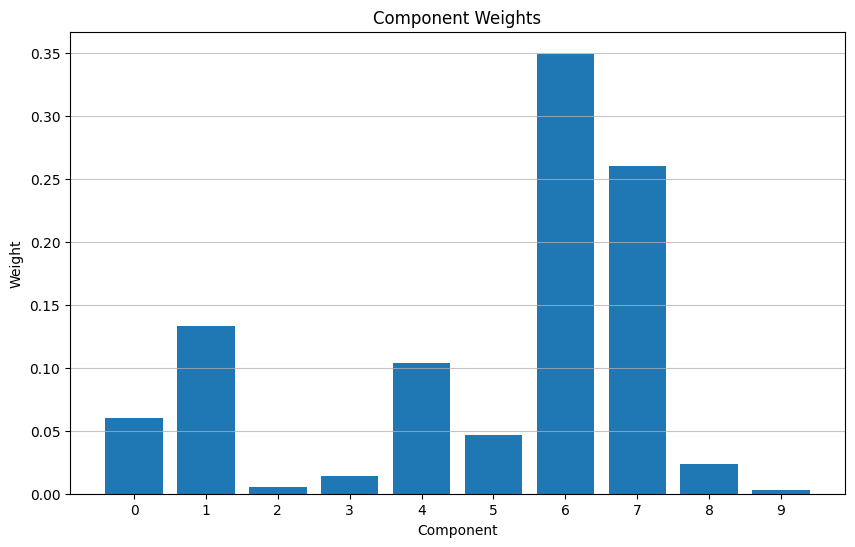

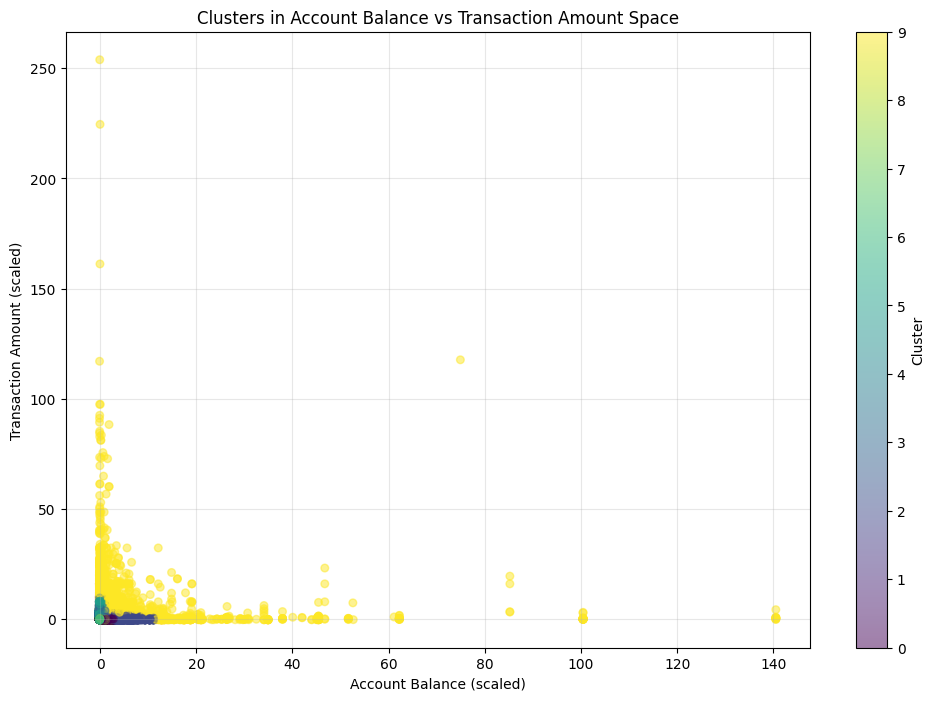


Cluster Statistics (for active clusters):
Cluster 0:
  Weight: 0.0604
  Size: 58311 (5.92%)
    CustGender: 1.0000
    CustLocation: 0.0417
    CustAccountBalance: 0.4980
    TransactionAmount (INR): -0.0860
    age: 0.4118
    unix_ts: 0.0115

Cluster 1:
  Weight: 0.1333
  Size: 133331 (13.53%)
    CustGender: 0.0000
    CustLocation: -0.0496
    CustAccountBalance: -0.1140
    TransactionAmount (INR): -0.1772
    age: -0.5043
    unix_ts: -0.0016

Cluster 3:
  Weight: 0.0140
  Size: 12526 (1.27%)
    CustGender: 0.0000
    CustLocation: -0.0120
    CustAccountBalance: 0.0554
    TransactionAmount (INR): 1.9027
    age: 0.5006
    unix_ts: 0.0052

Cluster 4:
  Weight: 0.1042
  Size: 102561 (10.41%)
    CustGender: 0.0000
    CustLocation: -0.0210
    CustAccountBalance: -0.0562
    TransactionAmount (INR): 0.0074
    age: 0.1757
    unix_ts: -0.0111

Cluster 5:
  Weight: 0.0467
  Size: 42091 (4.27%)
    CustGender: 1.0000
    CustLocation: 0.0410
    CustAccountBalance: 0.0384
    Tr

In [28]:
from sklearn.mixture import BayesianGaussianMixture

# For large datasets, use a sample for initial exploration
sample_size = min(100000, len(transformed_data))
sample_indices = np.random.choice(transformed_data.index, len(transformed_data), replace=False)
sample_data = transformed_data.loc[sample_indices]

# Initialize the BayesianGaussianMixture model
bgm = BayesianGaussianMixture(
    n_components=10,  # Upper bound on components
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,  # Controls how many components are used
    covariance_type='full',
    random_state=42,
    max_iter=100,
    n_init=3,
    verbose=1
)

# Fit the model to the sample data
print(f"Fitting BayesianGaussianMixture model on {sample_size} samples...")
bgm.fit(sample_data)

# Predict the cluster labels for the sample data
sample_data['cluster'] = bgm.predict(sample_data)

# Analyze the components
effective_components = sum(bgm.weights_ > 0.01)
print(f"Effective number of components: {effective_components}")

# Visualize component weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(bgm.weights_)), bgm.weights_)
plt.title('Component Weights')
plt.xlabel('Component')
plt.ylabel('Weight')
plt.xticks(range(len(bgm.weights_)))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize clusters in 2D feature space (Account Balance vs Transaction Amount)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sample_data['CustAccountBalance'], 
    sample_data['TransactionAmount (INR)'],
    c=sample_data['cluster'], 
    cmap='viridis', 
    alpha=0.5,
    s=30,
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters in Account Balance vs Transaction Amount Space')
plt.xlabel('Account Balance (scaled)')
plt.ylabel('Transaction Amount (scaled)')
plt.grid(alpha=0.3)
plt.show()

# Apply the model to the full dataset
transformed_data['cluster'] = bgm.predict(transformed_data)

# Print summary statistics for each active cluster
print("\nCluster Statistics (for active clusters):")
for i in range(len(bgm.weights_)):
    if bgm.weights_[i] > 0.01:  # Only show active clusters
        cluster_data = transformed_data[transformed_data['cluster'] == i]
        print(f"Cluster {i}:")
        print(f"  Weight: {bgm.weights_[i]:.4f}")
        print(f"  Size: {len(cluster_data)} ({len(cluster_data)/len(transformed_data)*100:.2f}%)")
        for col in transformed_data.columns[:-1]:  # Excluding the cluster column
            print(f"    {col}: {cluster_data[col].mean():.4f}")
        print()

## On voit que beaucoup des component sont négligeable donc on peut limitée l'entrainement a 5 components

Fitting BayesianGaussianMixture model on 100000 samples...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged.
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged.
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged.
Effective number of components: 5


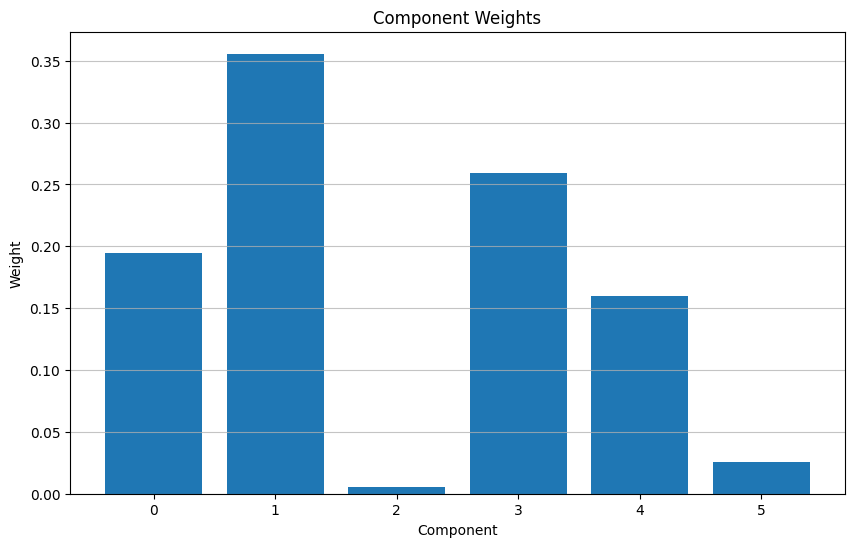

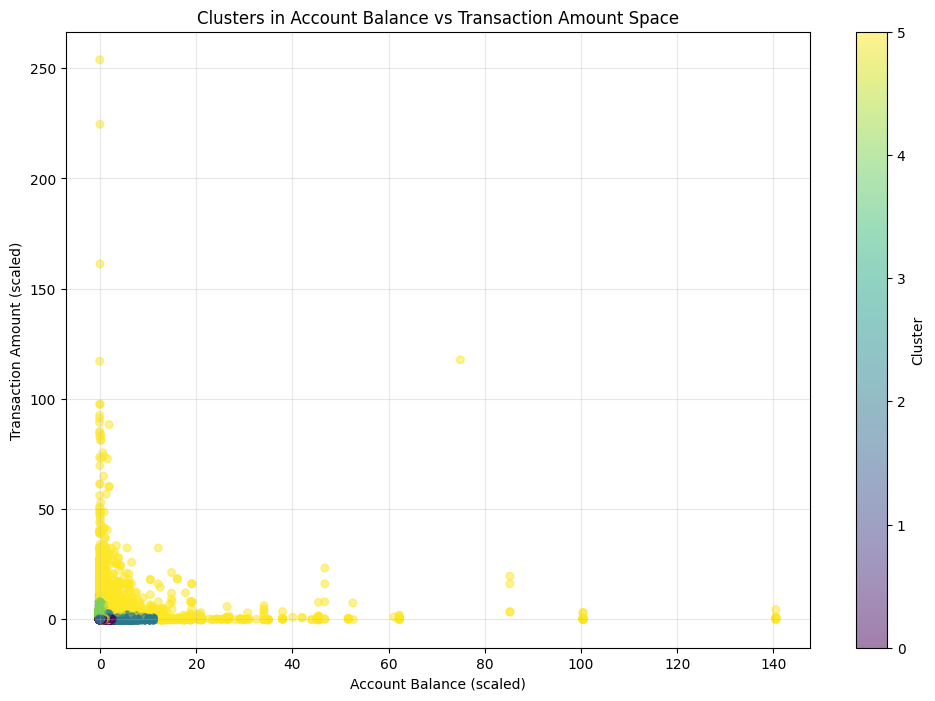


Cluster Statistics (for active clusters):
Cluster 0:
  Weight: 0.1945
  Size: 191642 (19.45%)
    CustGender: 0.3043
    CustLocation: -0.0218
    CustAccountBalance: 0.0722
    TransactionAmount (INR): -0.1494
    age: -0.2256
    unix_ts: 0.0024

Cluster 1:
  Weight: 0.3557
  Size: 350436 (35.57%)
    CustGender: 1.0000
    CustLocation: 0.0055
    CustAccountBalance: -0.1186
    TransactionAmount (INR): -0.1954
    age: -0.3622
    unix_ts: 0.0036

Cluster 3:
  Weight: 0.2592
  Size: 255353 (25.92%)
    CustGender: 1.0000
    CustLocation: 0.0113
    CustAccountBalance: -0.0767
    TransactionAmount (INR): -0.0410
    age: 0.2506
    unix_ts: -0.0032

Cluster 4:
  Weight: 0.1595
  Size: 157178 (15.95%)
    CustGender: 0.2678
    CustLocation: -0.0037
    CustAccountBalance: -0.0219
    TransactionAmount (INR): 0.5066
    age: 0.4505
    unix_ts: -0.0074

Cluster 5:
  Weight: 0.0257
  Size: 25345 (2.57%)
    CustGender: 0.0799
    CustLocation: -0.0111
    CustAccountBalance: 1.1423

In [29]:
from sklearn.mixture import BayesianGaussianMixture

# For large datasets, use a sample for initial exploration
sample_size = min(100000, len(transformed_data))
sample_indices = np.random.choice(transformed_data.index, len(transformed_data), replace=False)
sample_data = transformed_data.loc[sample_indices]

# Initialize the BayesianGaussianMixture model
bgm = BayesianGaussianMixture(
    n_components=6,  # Upper bound on components
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,  # Controls how many components are used
    covariance_type='full',
    random_state=42,
    max_iter=100,
    n_init=3,
    verbose=1
)

# Fit the model to the sample data
print(f"Fitting BayesianGaussianMixture model on {sample_size} samples...")
bgm.fit(sample_data)

# Predict the cluster labels for the sample data
sample_data['cluster'] = bgm.predict(sample_data)

# Analyze the components
effective_components = sum(bgm.weights_ > 0.01)
print(f"Effective number of components: {effective_components}")

# Visualize component weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(bgm.weights_)), bgm.weights_)
plt.title('Component Weights')
plt.xlabel('Component')
plt.ylabel('Weight')
plt.xticks(range(len(bgm.weights_)))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize clusters in 2D feature space (Account Balance vs Transaction Amount)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sample_data['CustAccountBalance'], 
    sample_data['TransactionAmount (INR)'],
    c=sample_data['cluster'], 
    cmap='viridis', 
    alpha=0.5,
    s=30,
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters in Account Balance vs Transaction Amount Space')
plt.xlabel('Account Balance (scaled)')
plt.ylabel('Transaction Amount (scaled)')
plt.grid(alpha=0.3)
plt.show()

# Apply the model to the full dataset
transformed_data['cluster'] = bgm.predict(transformed_data)

# Print summary statistics for each active cluster
print("\nCluster Statistics (for active clusters):")
for i in range(len(bgm.weights_)):
    if bgm.weights_[i] > 0.01:  # Only show active clusters
        cluster_data = transformed_data[transformed_data['cluster'] == i]
        print(f"Cluster {i}:")
        print(f"  Weight: {bgm.weights_[i]:.4f}")
        print(f"  Size: {len(cluster_data)} ({len(cluster_data)/len(transformed_data)*100:.2f}%)")
        for col in transformed_data.columns[:-1]:  # Excluding the cluster column
            print(f"    {col}: {cluster_data[col].mean():.4f}")
        print()

## Essayons maintenant un autre model:le MeanShift

Estimated bandwidth: 2.2722
Fitting MeanShift model on 100000 samples...
Number of clusters found: 132


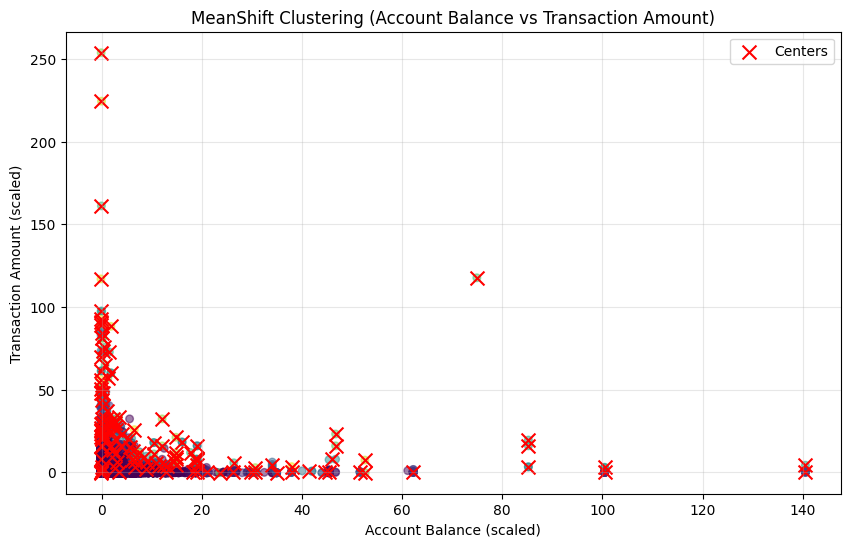


Cluster Statistics:
Cluster 0:
  Size: 539779 (54.78%)
  Center (Balance, Amount): (-0.0768, -0.1824)
    CustGender mean: 0.7530
    CustLocation mean: -0.0044
    CustAccountBalance mean: -0.0604
    TransactionAmount (INR) mean: -0.1797
    age mean: -0.3228
    unix_ts mean: 0.0030

Cluster 1:
  Size: 429802 (43.62%)
  Center (Balance, Amount): (-0.0526, 0.0403)
    CustGender mean: 0.6842
    CustLocation mean: 0.0050
    CustAccountBalance mean: -0.0289
    TransactionAmount (INR) mean: 0.1275
    age mean: 0.3120
    unix_ts mean: -0.0051

Cluster 2:
  Size: 6699 (0.68%)
  Center (Balance, Amount): (3.5029, 0.2017)
    CustGender mean: 0.8507
    CustLocation mean: 0.0460
    CustAccountBalance mean: 3.2215
    TransactionAmount (INR) mean: 0.2382
    age mean: 1.5293
    unix_ts mean: 0.0337

Cluster 3:
  Size: 2848 (0.29%)
  Center (Balance, Amount): (-0.0795, -0.0537)
    CustGender mean: 0.6808
    CustLocation mean: 0.2131
    CustAccountBalance mean: -0.0052
    Transacti

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Pour les gros jeux de données, on travaille d'abord sur un échantillon
sample_size = min(100000, len(transformed_data))
sample_indices = np.random.choice(transformed_data.index, len(transformed_data), replace=False)
sample_data = transformed_data.loc[sample_indices]

# Estimation automatique du paramètre bandwidth à partir de l'échantillon
bandwidth = estimate_bandwidth(sample_data, quantile=0.2, n_samples=5000, random_state=42)
print(f"Estimated bandwidth: {bandwidth:.4f}")

# Initialisation du modèle MeanShift
ms = MeanShift(
    bandwidth=bandwidth,
    bin_seeding=True,      # accélère en faisant un "binning" initial
    cluster_all=False,      # assigne chaque point au cluster le plus proche
    n_jobs=-4              # parallélisation

)

# Ajustement sur l'échantillon
print(f"Fitting MeanShift model on {sample_size} samples...")
ms.fit(sample_data)

# Obtention des labels et des centres de clusters
sample_data['cluster'] = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(ms.labels_))
print(f"Number of clusters found: {n_clusters}")

# Visualisation des centres (en 2D si on veut projeter)
plt.figure(figsize=(10, 6))
plt.scatter(
    sample_data['CustAccountBalance'],
    sample_data['TransactionAmount (INR)'],
    c=sample_data['cluster'],
    cmap='viridis',
    alpha=0.5,
    s=30
)
plt.scatter(
    cluster_centers[:, sample_data.columns.get_loc('CustAccountBalance')],
    cluster_centers[:, sample_data.columns.get_loc('TransactionAmount (INR)')],
    c='red', marker='x', s=100, label='Centers'
)
plt.title('MeanShift Clustering (Account Balance vs Transaction Amount)')
plt.xlabel('Account Balance (scaled)')
plt.ylabel('Transaction Amount (scaled)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Application du modèle sur l'ensemble du jeu de données
full_labels = ms.predict(transformed_data)
transformed_data['cluster'] = full_labels

# Statistiques pour chaque cluster
print("\nCluster Statistics:")
for cluster_id in np.unique(full_labels):
    cluster_data = transformed_data[transformed_data['cluster'] == cluster_id]
    size = len(cluster_data)
    pct = size / len(transformed_data) * 100
    center = cluster_centers[cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"  Size: {size} ({pct:.2f}%)")
    print(f"  Center (Balance, Amount): ({center[sample_data.columns.get_loc('CustAccountBalance')]:.4f}, "
          f"{center[sample_data.columns.get_loc('TransactionAmount (INR)')]:.4f})")
    for col in transformed_data.columns.drop('cluster'):
        print(f"    {col} mean: {cluster_data[col].mean():.4f}")
    print()

## Au vu des resultats précédents je souhaite essayer sans les valeurs les plus haute afin de visualiser le clusters sur les donnée regroupé

In [31]:
data = transformed_data.copy()
# data = data.drop(data[data['CustAccountBalance'] > 25].index)
data = data.drop(data[data['CustAccountBalance'] > 50].index)
# data = data.drop(data[data['TransactionAmount (INR)'] > 25].index)
data = data.drop(data[data['TransactionAmount (INR)'] > 50].index)

Fitting BayesianGaussianMixture model on 100000 samples...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged.
Effective number of components: 5


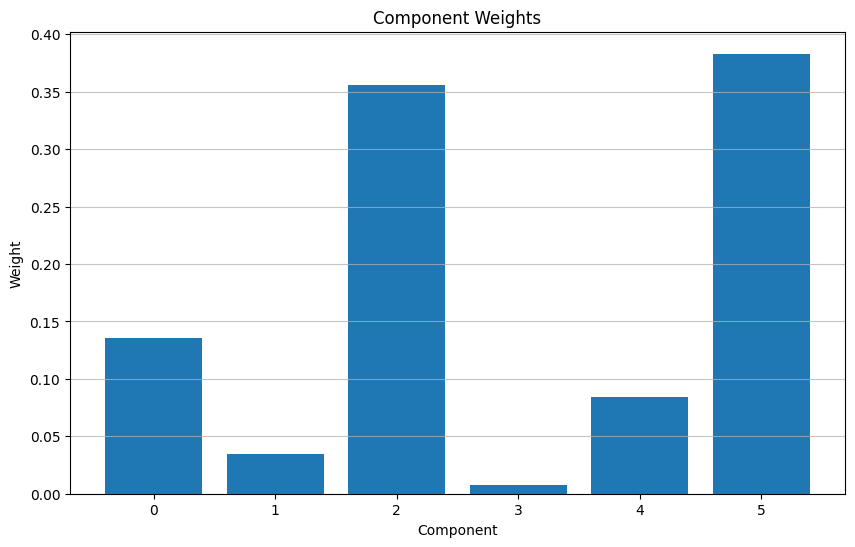

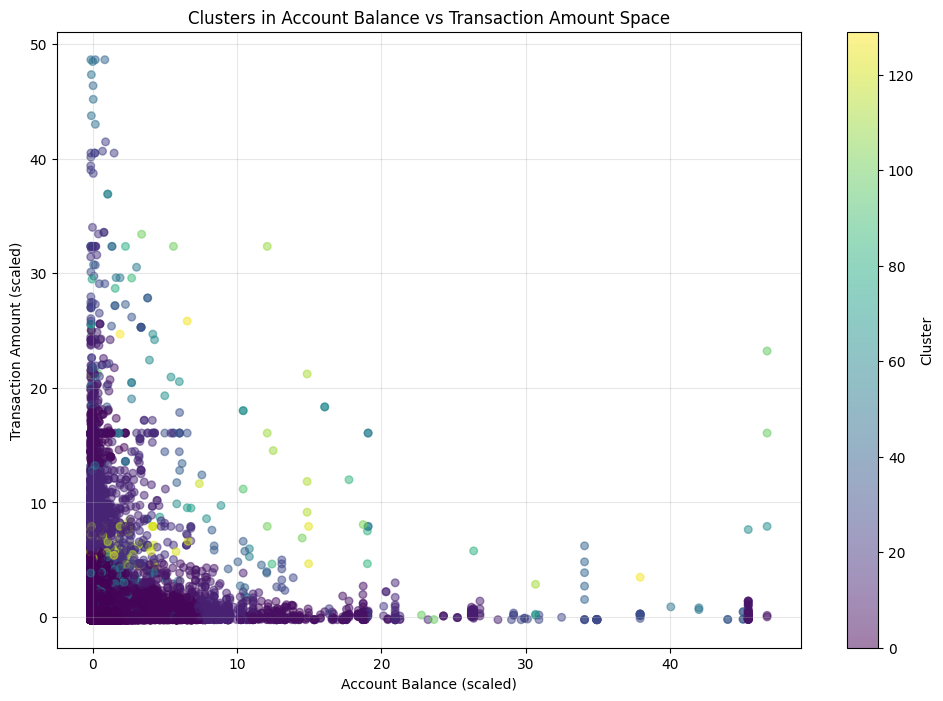


Cluster Statistics (for active clusters):
Cluster 0:
  Weight: 0.1353
  Size: 133331 (13.53%)
    CustGender: 0.0000
    CustLocation: -0.0496
    CustAccountBalance: -0.1140
    TransactionAmount (INR): -0.1772
    age: -0.5043
    unix_ts: -0.0016

Cluster 1:
  Weight: 0.0345
  Size: 383320 (38.91%)
    CustGender: 0.9794
    CustLocation: 0.0061
    CustAccountBalance: -0.0636
    TransactionAmount (INR): -0.0459
    age: -0.2285
    unix_ts: 0.0040

Cluster 2:
  Weight: 0.3557
  Size: 0 (0.00%)
    CustGender: nan
    CustLocation: nan
    CustAccountBalance: nan
    TransactionAmount (INR): nan
    age: nan
    unix_ts: nan

Cluster 4:
  Weight: 0.0843
  Size: 105 (0.01%)
    CustGender: 0.0000
    CustLocation: 0.2978
    CustAccountBalance: 1.1542
    TransactionAmount (INR): -0.0140
    age: 4.1116
    unix_ts: -0.1335

Cluster 5:
  Weight: 0.3830
  Size: 1632 (0.17%)
    CustGender: 0.6495
    CustLocation: 0.1550
    CustAccountBalance: -0.0768
    TransactionAmount (INR): -

In [32]:
from sklearn.mixture import BayesianGaussianMixture

# For large datasets, use a sample for initial exploration
sample_size = min(100000, len(data))
sample_indices = np.random.choice(data.index, len(data), replace=False)
sample_data = data.loc[sample_indices]

# Initialize the BayesianGaussianMixture model
bgm = BayesianGaussianMixture(
    n_components=6,  # Upper bound on components
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.1,  # Controls how many components are used
    covariance_type='full',
    random_state=42,
    max_iter=100,
    n_init=3,
    verbose=1,
)

# Fit the model to the sample data
print(f"Fitting BayesianGaussianMixture model on {sample_size} samples...")
bgm.fit(data)

# Predict the cluster labels for the sample data
data['cluster'] = bgm.predict(data)

# Analyze the components
effective_components = sum(bgm.weights_ > 0.01)
print(f"Effective number of components: {effective_components}")

# Visualize component weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(bgm.weights_)), bgm.weights_)
plt.title('Component Weights')
plt.xlabel('Component')
plt.ylabel('Weight')
plt.xticks(range(len(bgm.weights_)))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize clusters in 2D feature space (Account Balance vs Transaction Amount)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sample_data['CustAccountBalance'], 
    sample_data['TransactionAmount (INR)'],
    c=sample_data['cluster'], 
    cmap='viridis', 
    alpha=0.5,
    s=30,
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters in Account Balance vs Transaction Amount Space')
plt.xlabel('Account Balance (scaled)')
plt.ylabel('Transaction Amount (scaled)')
plt.grid(alpha=0.3)
plt.show()

# Apply the model to the full dataset
data['cluster'] = bgm.predict(data)

# Print summary statistics for each active cluster
print("\nCluster Statistics (for active clusters):")
for i in range(len(bgm.weights_)):
    if bgm.weights_[i] > 0.01:  # Only show active clusters
        cluster_data = data[data['cluster'] == i]
        print(f"Cluster {i}:")
        print(f"  Weight: {bgm.weights_[i]:.4f}")
        print(f"  Size: {len(cluster_data)} ({len(cluster_data)/len(data)*100:.2f}%)")
        for col in data.columns[:-1]:  # Excluding the cluster column
            print(f"    {col}: {cluster_data[col].mean():.4f}")
        print()

Estimated bandwidth: 2.2080
Fitting MeanShift model on 985234 samples...
Number of clusters found: 102


/var/folders/m9/n5d54_nd60l_9j9pz5np7rsm0000gn/T/ipykernel_97261/1041664157.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


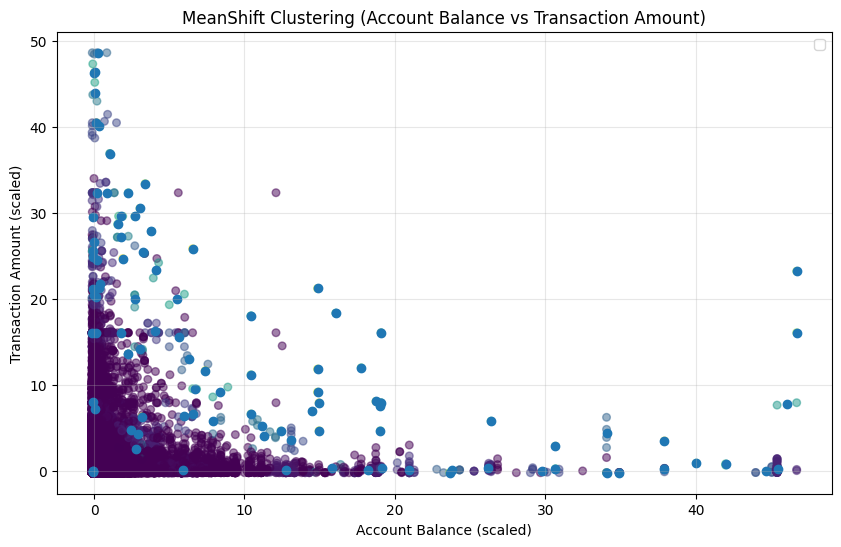


Cluster Statistics:
Cluster 0:
  Size: 968977 (98.35%)
  Center (Balance, Amount): (-0.0543, -0.0880)
    CustGender mean: 0.7232
    CustLocation mean: -0.0006
    CustAccountBalance mean: -0.0386
    TransactionAmount (INR) mean: -0.0556
    age mean: -0.0441
    unix_ts mean: -0.0004

Cluster 1:
  Size: 3704 (0.38%)
  Center (Balance, Amount): (0.0717, 7.2173)
    CustGender mean: 0.6890
    CustLocation mean: -0.0184
    CustAccountBalance mean: 0.0734
    TransactionAmount (INR) mean: 6.4599
    age mean: 0.3918
    unix_ts mean: -0.0649

Cluster 2:
  Size: 2744 (0.28%)
  Center (Balance, Amount): (5.9065, 0.0747)
    CustGender mean: 0.8371
    CustLocation mean: 0.0738
    CustAccountBalance mean: 5.2976
    TransactionAmount (INR) mean: 0.1526
    age mean: 1.1774
    unix_ts mean: -0.0105

Cluster 3:
  Size: 3935 (0.40%)
  Center (Balance, Amount): (-0.0845, -0.0390)
    CustGender mean: 0.6877
    CustLocation mean: 0.3071
    CustAccountBalance mean: 0.0448
    TransactionA

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Pour les gros jeux de données, on travaille d'abord sur un échantillon
sample_size = min(100000, len(data))
sample_indices = np.random.choice(data.index, len(data), replace=False)
sample_data = data.loc[sample_indices]

# Estimation automatique du paramètre bandwidth à partir de l'échantillon
bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=5000, random_state=42)
print(f"Estimated bandwidth: {bandwidth:.4f}")

# Initialisation du modèle MeanShift
ms = MeanShift(
    bandwidth=bandwidth,
    bin_seeding=True,      # accélère en faisant un "binning" initial
    cluster_all=False,      # assigne chaque point au cluster le plus proche
    n_jobs=-4              # parallélisation

)

# Ajustement sur l'échantillon
print(f"Fitting MeanShift model on {len(data)} samples...")
ms.fit(data)

# Obtention des labels et des centres de clusters
data['cluster'] = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(ms.labels_))
print(f"Number of clusters found: {n_clusters}")

# Visualisation des centres (en 2D si on veut projeter)
plt.figure(figsize=(10, 6))
plt.scatter(
    data['CustAccountBalance'],
    data['TransactionAmount (INR)'],
    c=data['cluster'],
    cmap='viridis',
    alpha=0.5,
    s=30
)
plt.scatter(
    cluster_centers[:, data.columns.get_loc('CustAccountBalance')],
    cluster_centers[:, data.columns.get_loc('TransactionAmount (INR)')],
    # c='red', marker='x', s=100, label='Centers'
)
plt.title('MeanShift Clustering (Account Balance vs Transaction Amount)')
plt.xlabel('Account Balance (scaled)')
plt.ylabel('Transaction Amount (scaled)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Application du modèle sur l'ensemble du jeu de données
full_labels = ms.predict(data)
data['cluster'] = full_labels

# Statistiques pour chaque cluster
print("\nCluster Statistics:")
for cluster_id in np.unique(full_labels):
    cluster_data = data[data['cluster'] == cluster_id]
    size = len(cluster_data)
    pct = size / len(data) * 100
    center = cluster_centers[cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"  Size: {size} ({pct:.2f}%)")
    print(f"  Center (Balance, Amount): ({center[data.columns.get_loc('CustAccountBalance')]:.4f}, "
          f"{center[sample_data.columns.get_loc('TransactionAmount (INR)')]:.4f})")
    for col in data.columns.drop('cluster'):
        print(f"    {col} mean: {cluster_data[col].mean():.4f}")
    print()


Silhouette moyenne : 0.3842


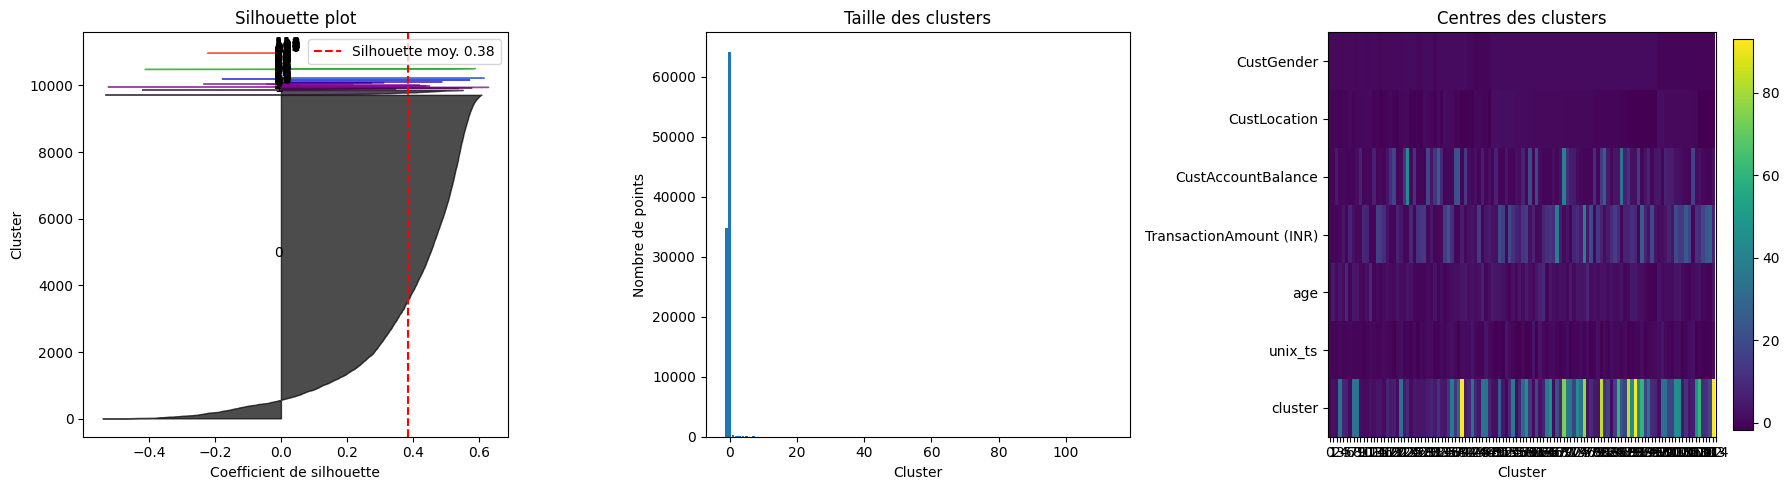

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import MeanShift, estimate_bandwidth

# --- 1) Estimation du bandwidth et fit sur un gros échantillon (100k max) ---
sample_size = min(100000, len(data))
sample = data.sample(n=sample_size, random_state=42)

bandwidth = estimate_bandwidth(sample, quantile=0.2, n_samples=5000, random_state=42)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, n_jobs=-1)
ms.fit(sample)

labels = ms.labels_
centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))

# --- 2) Silhouette (échantillon de 10k pour la vitesse) ---
sil_sample = sample.sample(n=10000, random_state=42)
sil_labels = ms.predict(sil_sample)
sil_vals = silhouette_samples(sil_sample, sil_labels)
sil_avg = silhouette_score(sil_sample, sil_labels)
print(f"Silhouette moyenne : {sil_avg:.4f}")

# --- 3) Préparation du DataFrame des centres ---
feature_cols = sample.columns.tolist()
center_df = pd.DataFrame(centers, columns=feature_cols)

# --- 4) Tracé en 3 panneaux ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 4.1 Silhouette plot
ax = axes[0]
y_lower = 10
for i in range(n_clusters):
    ith_vals = np.sort(sil_vals[sil_labels == i])
    size_i = ith_vals.shape[0]
    y_upper = y_lower + size_i
    color = plt.cm.nipy_spectral(i / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.02, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10
ax.set_title("Silhouette plot")
ax.set_xlabel("Coefficient de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=sil_avg, color="red", linestyle="--", label=f"Silhouette moy. {sil_avg:.2f}")
ax.legend()

# 4.2 Histogramme des tailles de clusters
ax = axes[1]
sizes = pd.Series(labels).value_counts().sort_index()
ax.bar(sizes.index, sizes.values)
ax.set_title("Taille des clusters")
ax.set_xlabel("Cluster")
ax.set_ylabel("Nombre de points")

# 4.3 Heatmap des centres de clusters
ax = axes[2]
im = ax.imshow(center_df.T, aspect="auto")
ax.set_title("Centres des clusters")
ax.set_xlabel("Cluster")
ax.set_xticks(np.arange(n_clusters))
ax.set_yticks(np.arange(len(feature_cols)))
ax.set_yticklabels(feature_cols)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

=== Top 10 variables pour PC1 ===
                              PC1     |PC1|
cluster                  0.973568  0.973568
TransactionAmount (INR)  0.198823  0.198823
age                      0.098700  0.098700
CustAccountBalance       0.053400  0.053400
CustLocation            -0.005448  0.005448
CustGender              -0.003171  0.003171
unix_ts                  0.001482  0.001482

=== Top 10 variables pour PC2 ===
                              PC2     |PC2|
TransactionAmount (INR)  0.970314  0.970314
cluster                 -0.180647  0.180647
age                     -0.112086  0.112086
CustAccountBalance      -0.108260  0.108260
CustLocation             0.030890  0.030890
unix_ts                 -0.024882  0.024882
CustGender              -0.000112  0.000112


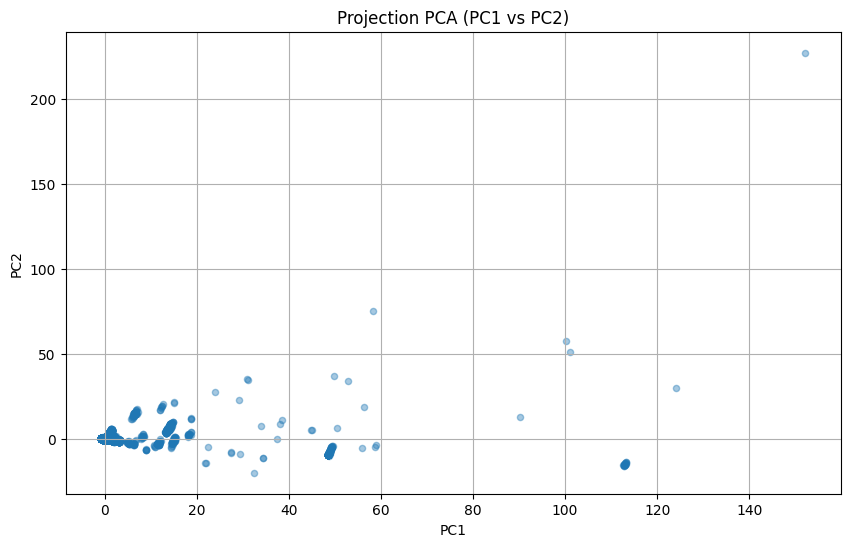

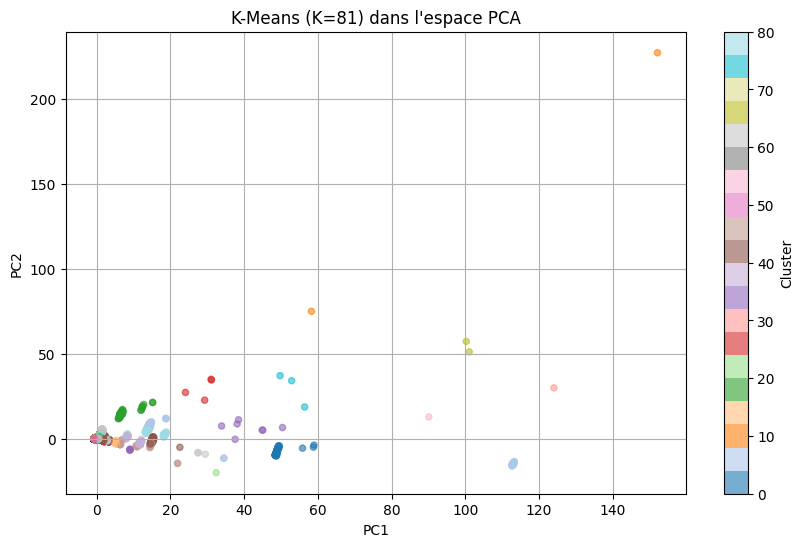


=== Statistiques par cluster (échantillon) ===

Cluster 0 — taille: 1191 (1.19%)
                             mean       std
CustGender               0.680940  0.466308
CustLocation             0.855807  0.525726
CustAccountBalance       0.046926  0.294001
TransactionAmount (INR)  0.045278  0.382601
age                      2.613393  0.594839

Cluster 1 — taille: 3154 (3.15%)
                             mean       std
CustGender               1.000000  0.000000
CustLocation            -1.214868  0.276962
CustAccountBalance      -0.086965  0.147760
TransactionAmount (INR) -0.190600  0.047985
age                     -0.606551  0.328724

Cluster 2 — taille: 136 (0.14%)
                             mean       std
CustGender               0.500000  0.501848
CustLocation            -0.741044  0.793859
CustAccountBalance       0.400158  1.097205
TransactionAmount (INR)  1.348000  1.774767
age                      4.159007  0.798149

Cluster 3 — taille: 1941 (1.94%)
                         

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Réglages & échantillon (pour accélérer)
np.random.seed(42)
sample_size = min(100000, len(transformed_data))
sample = transformed_data.sample(sample_size, random_state=42)

# 2. PCA à 2 composantes pour exploration
pca = PCA(n_components=2, random_state=42)
pca_scores = pca.fit_transform(sample)
pca_df = pd.DataFrame(pca_scores, columns=['PC1','PC2'], index=sample.index)

# 3. Extraction des loadings (poids des features)
loading_df = pd.DataFrame(
    pca.components_.T,
    index=transformed_data.columns,
    columns=['PC1','PC2']
)
# Ajout des magnitudes pour trier
loading_df['|PC1|'] = loading_df['PC1'].abs()
loading_df['|PC2|'] = loading_df['PC2'].abs()

# Affichage du top 10 features pour PC1 et PC2
top_PC1 = loading_df.sort_values('|PC1|', ascending=False).head(10)
top_PC2 = loading_df.sort_values('|PC2|', ascending=False).head(10)

print("=== Top 10 variables pour PC1 ===")
print(top_PC1[['PC1','|PC1|']])
print("\n=== Top 10 variables pour PC2 ===")
print(top_PC2[['PC2','|PC2|']])

# 4. Scatter des points en espace PCA
plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.4, s=20)
plt.title("Projection PCA (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# 5. K-Means (ici sur l'échantillon, mais vous pouvez faire sur tout transformed_data)
optimal_k = 81
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(sample)

# Ajout des labels au DataFrame PCA
pca_df['cluster'] = cluster_labels

# 6. Scatter des clusters en espace PCA
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['cluster'], cmap='tab20', alpha=0.6, s=20
)
plt.title(f"K-Means (K={optimal_k}) dans l'espace PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

# 7. Statistiques sommaires par cluster (sur l'échantillon)
print("\n=== Statistiques par cluster (échantillon) ===")
for i in range(optimal_k):
    idx = pca_df['cluster']==i
    if idx.sum()==0:
        continue
    print(f"\nCluster {i} — taille: {idx.sum()} ({idx.mean()*100:.2f}%)")
    desc = sample.loc[idx, transformed_data.columns]\
                .agg(['mean','std']).T
    print(desc.head(5))   # n’affiche que les 5 premières variables par exemple

# (Optionnel) Enregistrer le tableau complet des loadings
loading_df.to_csv("pca_loadings.csv")
print("\nLe tableau des loadings a été sauvegardé dans 'pca_loadings.csv'.")

In [36]:
from rich.progress import Progress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Chargement et préparation des données
# Remplacez ceci par votre DataFrame réel
# transformed_data = pd.read_csv('votre_fichier.csv')  
# Ici j'imagine que transformed_data existe déjà dans l'environnement

# 2. Paramètres pour la recherche du nombre optimal de clusters
k_min, k_max = 240, 320  # Plage autour des 270-290 estimés
k_range = range(k_min, k_max + 1)

# 3. Liste pour stocker les résultats
inertias = []
silhouette_scores = []

# 4. Prelever un échantillon pour le score de silhouette (plus rapide)
sil_sample = transformed_data.sample(n=100000, random_state=42)

# 5. Boucle avec barre de progression Rich
with Progress() as progress:
    task = progress.add_task("[green]Recherche du k optimal...", total=len(k_range))
    for k in k_range:
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        kmeans.fit(transformed_data)
        inertias.append(kmeans.inertia_)
        
        # Silhouette sur l'échantillon
        labels = kmeans.predict(sil_sample)
        silhouette_scores.append(silhouette_score(sil_sample, labels))
        
        progress.update(task, advance=1)

# 6. Visualisation des résultats
plt.figure(figsize=(12, 5))

# Elbow (inertie)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude (Inertie)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.grid(True)

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title("Score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


Output()

: 

: 

In [ ]:
from rich.progress import Progress
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- 1. Préparation des données (échantillon déjà standardisé)
sample = scaled_df.sample(200_000, random_state=42)
sil_sample = sample.sample(50_000, random_state=42)

k_min, k_max = 240, 320
k_values = list(range(k_min, k_max + 1))

def eval_k(k):
    mbk = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=10_000,
        max_no_improvement=10,
        init="k-means++"
    )
    mbk.fit(sample)
    inertia = mbk.inertia_
    sil = silhouette_score(sil_sample, mbk.predict(sil_sample))
    return k, inertia, sil

inertias = []
silhouettes = []

with Progress() as progress:
    task = progress.add_task("[green]Recherche du k optimal...", total=len(k_values))
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(eval_k, k): k for k in k_values}
        for future in as_completed(futures):
            k, inertia, sil = future.result()
            inertias.append((k, inertia))
            silhouettes.append((k, sil))
            progress.update(task, advance=1)

# Tri et affichage des courbes (mêmes étapes que précédemment)…


Output()

In [ ]:
# Avant la boucle, une seule fois :
np.save("sample.npy", sample.values)
np.save("sil_sample.npy", sil_sample.values)

def eval_k(k):
    X = np.load("sample.npy", mmap_mode="r")
    S = np.load("sil_sample.npy", mmap_mode="r")
    mbk = MiniBatchKMeans(...).fit(X)
    return k, mbk.inertia_, silhouette_score(S, mbk.predict(S))
